# CUDA C Best Practices Guide -- Shared Memory Optimisations

Ensure the binary is up to date

In [101]:
! make clean
! make

rm sbd lsb.*.r0* aiwc_*.csv aiwc_*_itb.log
rm: cannot remove 'aiwc_*.csv': No such file or directory
rm: cannot remove 'aiwc_*_itb.log': No such file or directory
Makefile:11: recipe for target 'clean' failed
make: *** [clean] Error 1
g++ synthetic-benchmark-driver.cpp -o sbd -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11


Run experiment and collect the tiny runtime data

In [102]:
! ./sbd ./gpu-strided-global-memory-access-unoptimised.cl tiny 0 0 runtime

***** LSB_Init >gpu_memory_access< writing to >lsb.gpu_memory_access.r0< *****
Attempting kernel: ./gpu-strided-global-memory-access-unoptimised.cl with contents:
//shared memory in matrix multiplication ported from the [cuda c best practices guide](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#shared-memory-in-matrix-multiplication-c-aa)

__kernel void simpleMultiply(__global float *a,__global float *b,__global float *c, int N)
{
    int row = get_group_id(1) * get_local_size(1) + get_local_id(1);//blockIdx.y * blockDim.y + threadIdx.y;
    int col = get_group_id(0) * get_local_size(0) + get_local_id(0);//blockIdx.x * blockDim.x + threadIdx.x;
    float sum = 0.0f;
    for (int i = 0; i < TILE_DIM; i++) {
        sum += a[row*TILE_DIM+i] * b[i*N+col];
    }
    c[row*TILE_DIM+col] = sum;
}

__kernel void coalescedMultiply(__global float* a, __global float* b, __global float* c, int N)
{
    __local float aTile[TILE_DIM][TILE_DIM];
    __local float bTile[TILE_DIM

Analyse the runtimes (to ensure the OpenCL port of the cuda codes matches those shown in their paper)

In [104]:

import pandas as pd
x = pd.read_csv('lsb.gpu_memory_access.r0', comment='#', sep="\s+")
#print(x)

y = x[(x.region == 'simpleMultiply_kernel') | (x.region == 'coalescedMultiply_kernel') | (x.region == 'transposedCoalescedMultiply_kernel')]

#%reload_ext rpy2.ipython

The distributions of 100 runtimes for each of the 3 kernels of memory striding for GPU optimisations are shown below.

/usr/local/lib/python3.5/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


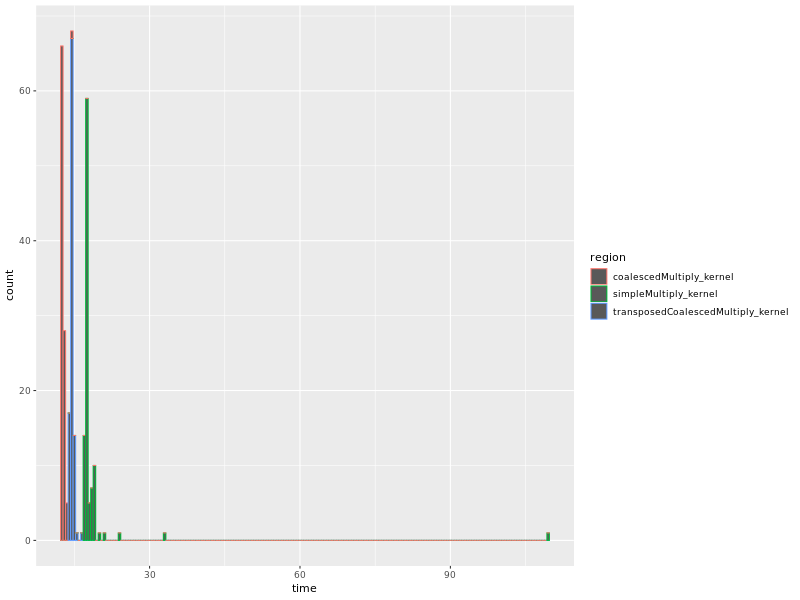

In [105]:
%%R -i y -w 800 -h 600 -u px

library(ggplot2)
pp = ggplot(y, aes_string(x='time', colour = 'region')) + geom_histogram(binwidth=.5)
print(pp)

**NOTE:** These distributions appear suspect! Perhaps move the timing regions to outside of the loop and divide by iterations -- in the C host source

Generate a representation of the AIWC feature-space changing between kernels